# Large Language Model Evaluation pipeline

### Background
One of the key challenge for our customers when evaluating open source models is the cost of hosting the model during experiment stage. As our customers are doing manual test, the resources are not fully ustilised and there are a lot of repeating when evaluating different LLMs.

The customer journey at the moment is like, they may have a list of questions, and they want to test different prompt template (different LLMs respond differently to the prompt templates), they may need to do a batch invocation against the endpoint, do some manually check, then change the template, invoke again and check. This is tedious and not scalable.

There are also different evaluation mechanisms that are used in LLM evaluation as shown in the below diagram. To evaluation the LLMs and prompt template against different evaluation approach needs to be standardized and automated to improve efficiency and reduce cost.

![Eval pipeline](./Assets/eval-metrics.png)

### Overview of the proposed auto-eval pipeline for LLMs
In this proposed solution, customer can use the evaluation pipeline and launch a temporary endpoint or use the API based LLM service, ran the test set against the endpoint/API service. Then launch another LLM or use another API LLM service (for evaluation purpose), they can then select the evaluation metrics from the metric factory. For example, as a sanity check, we validate the outputs of the target test LLM can be directly derived based on the input context. In this way, we are converting the LLM evaluation into a classification problem to ask the eval LLM to answer 'yes' or 'no'. This is the similar process that human evaluator will perform. If the evaluation metrics fall into the traditional ML evaluation metrics, such as the cosine similarity, we can also calculate this value using the corresponding lambda function. Once the evaluation is done, users will get a list of inputs, outputs and evaluation results, they can easily compare different LLMs, prompt templates and the combination of the two. This will significantly save customer’s cost and time during evaluation stage.

## Architecture
Below is an architecture diagram of the proposed LLM auto-eval pipeline. In this note book, we are implementing each function in different notebook cells and are working towards implementing each component into a dedicated AWS services, or we can call them micro-services for reusability and scalability.

![Eval metrics](./Assets/eval-prompt-ops.png)

## Updating AWS Python SDK

In [5]:
!pip install botocore boto3 jsonpath_ng --upgrade --quiet

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.4.2 requires botocore<1.27.60,>=1.27.59, but you have botocore 1.31.61 which is incompatible.
awscli 1.29.26 requires botocore==1.31.26, but you have botocore 1.31.61 which is incompatible.
awscli 1.29.26 requires rsa<4.8,>=3.1.2, but you have rsa 4.9 which is incompatible.
awscli 1.29.26 requires s3transfer<0.7.0,>=0.6.0, but you have s3transfer 0.7.0 which is incompatible.


## Setting up SageMaker 

Only run the below cells if you are going to test the open-source models that are hosted on SageMaker. If you are going to evaluate the API based LLM services, such as models provided by bedrock, you can skip the below cells.

In [7]:
# from sagemaker.model import Model
# from sagemaker import get_execution_role
# from sagemaker.huggingface import get_huggingface_llm_image_uri
# from sagemaker.huggingface import HuggingFaceModel
# # retrieve the llm image uri
# llm_image = get_huggingface_llm_image_uri(
#   "huggingface",
#   version="0.8.2"
# )

# role = get_execution_role()
# hf_model_id = "tiiuae/falcon-7b-instruct" # model id from huggingface.co/models
# model_name = hf_model_id.replace("/","-").replace(".","-")
# endpoint_name = "test-sagemaker"
# instance_type = "ml.g5.2xlarge" # instance type to use for deployment
# number_of_gpus = 1 # number of gpus to use for inference and tensor parallelism
# health_check_timeout = 2400 # Increase the timeout for the health check to 5 minutes for downloading the model

# llm_model = HuggingFaceModel(
#       role=role,
#       image_uri=llm_image,
#       env={
#         'HF_MODEL_ID': hf_model_id,
#         # 'HF_MODEL_QUANTIZE': "bitsandbytes", # comment in to quantize
#         'SM_NUM_GPUS': f"{number_of_gpus}",
#         'MAX_INPUT_LENGTH': "3000",  # Max length of input text
#         'MAX_TOTAL_TOKENS': "6000",  # Max length of the generation (including input text)
#       },
#       name=model_name
#     )

# llm = llm_model.deploy(
#   initial_instance_count=1,
#   instance_type=instance_type,
#   container_startup_health_check_timeout=health_check_timeout,
#   endpoint_name=endpoint_name,
# )

Using already existing model: tiiuae-falcon-7b-instruct


-----------------!

In [5]:
# model_family = "sagemaker"
# endpoint_name = "test-sagemaker"
# container_type = "tgi"
# model_name = f"{container_type}.{endpoint_name}"

In [6]:
# from importlib import import_module
# model = import_module("handlers." + model_family).model(model_name)

In [7]:
# model.invoke({"prompt": "\n\nHuman: Hello. Who are you?\n\nAssistant:"})["generated_text"]

" I'm an AI assistant designed to assist humans with various tasks and inquiries. How can I help"

## Lambda function simulation

### Batch prompt dataset

We firstly prepare the test dataset, which consists of the input queries, context (this can be derived by a RAG service), and the expected output as groundtruth.

In [10]:
%%writefile prompt_dataset.csv
id|QUESTION|CONTEXT|Expected Answer
1|Which regions support spot instances for training?|Managed Spot Training can be used with all instances supported in Amazon SageMaker. Managed Spot Training is supported in all AWS Regions where Amazon SageMaker is currently available.|all AWS regions
2|Does SageMaker provide any free ML environments?|SageMaker includes the following machine learning environments:  SageMaker Canvas: An auto ML service that gives people with no coding experience the ability to build models and make predictions with them. SageMaker Studio:   An integrated machine learning environment where you can build, train, deploy, and analyze your models all in the same application. SageMaker Studio Lab: A free service that gives customers access to AWS compute resources in an environment based on open-source JupyterLab. RStudio on Amazon SageMaker: An integrated development environment for R, with a console, syntax-highlighting editor that supports direct code execution, and tools for plotting, history, debugging and workspace management.|Yes, SageMaker Studio Lab provides a free service that gives customers access to AWS compute resources in an environment based on open-source JupyterLab.
3|What are some of the ways to access JumpStart?|SageMaker JumpStart provides pretrained, open-source models for a wide range of problem types to help you get started with machine learning. You can incrementally train and tune these models before deployment. JumpStart also provides solution templates that set up infrastructure for common use cases, and executable example notebooks for machine learning with SageMaker. You can access the pretrained models, solution templates, and examples through the JumpStart landing page in Amazon SageMaker Studio. You can also access JumpStart models using the SageMaker Python SDK.|You can access the pretrained models, solution templates, and examples through the JumpStart landing page in Amazon SageMaker Studio and the SageMaker Python SDK.
4|Can Ground Truth help me save my labelling costs? If so, how?|To train a machine learning model, you need a large, high-quality, labeled dataset. You can label your data using Amazon SageMaker Ground Truth. Choose from one of the Ground Truth built-in task types or create your own custom labeling workflow. To improve the accuracy of your data labels and reduce the total cost of labeling your data, use Ground Truth enhanced data labeling features like automated data labeling and annotation consolidation. |Yes, Ground Truth can help you save your labelling costs by using features like automated data labelling and annotation consolidation.
5|Which SageMaker feature can help me prepare my datasets for model training?|To analyze data and evaluate machine learning models on Amazon SageMaker, use Amazon SageMaker Processing. With Processing, you can use a simplified, managed experience on SageMaker to run your data processing workloads, such as feature engineering, data validation, model evaluation, and model interpretation. Your input data must be stored in an Amazon S3 bucket. Alternatively, you can use Amazon Athena or Amazon Redshift as input sources.|Amazon SageMaker Processing can help you analyze and process your data.
6|Can SageMaker alert me if a model's accuracy goes down?|Amazon SageMaker Model Monitor monitors the quality of Amazon SageMaker machine learning models in production. You can set up continuous monitoring with a real-time endpoint (or a batch transform job that runs regularly), or on-schedule monitoring for asynchronous batch transform jobs. With Model Monitor, you can set alerts that notify you when there are deviations in the model quality. Model Monitor provides the following types of monitoring: Monitor drift in data quality, Monitor drift in model quality metrics, such as accuracy. Monitor bias in your model's predictions, Monitor drift in feature attribution.|Yes, Amazon SageMaker Model Monitor can alert you if a model's accuracy goes down.
7|Who is responsible for data security?|Security is a shared responsibility between AWS and you. The shared responsibility model describes this as security of the cloud and security in the cloud: Security of the cloud – AWS is responsible for protecting the infrastructure that runs AWS services in the AWS Cloud. AWS also provides you with services that you can use securely. Security in the cloud – Your responsibility is determined by the AWS service that you use. You are also responsible for other factors including the sensitivity of your data, your company’s requirements, and applicable laws and regulations. |AWS and the customer
8|How can I track who made a SageMaker API call?|Monitoring is an important part of maintaining the reliability, availability, and performance of SageMaker and your other AWS solutions. AWS provides the following monitoring tools: Amazon CloudWatch monitors your AWS resources and the applications that you run on AWS in real time. Amazon CloudWatch Logs enables you to monitor, store, and access your log files. AWS CloudTrail captures API calls and related events made by or on behalf of your AWS account. CloudWatch Events delivers a near real-time stream of system events that describe changes in AWS resources. |AWS CloudTrail captures API calls and related events made by or on behalf of your AWS account.

Writing prompt_dataset.csv


### Batch Prompt Generation

The following section generates the output based on the selected prompt template and all the test cases.

In [6]:
from prompts.store import TemplateStore
import pandas as pd
from typing import List, Dict

prompt_template_database = TemplateStore()

In [12]:
from importlib import import_module
from prompts.template import PromptTemplate
    
def handler(event, context):
    model = import_module("handlers." + event["model_family"]).model(event["model_name"])
    prompt = prompt_template_database.get_prompt_from_template(
        template_id=event["template_id"], 
        param_values=event["template_params"]
    )
    return model.invoke({"prompt": prompt})["generated_text"]

if __name__=="__main__":
    p_template = PromptTemplate(
        template="""Human: Use the following pieces of context to provide a concise answer to the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.
{CONTEXT}

Question: {Question_text}
Assistant:""",
        params=["CONTEXT", "Question_text"]
    )    
    prompt_template_database.add_template(
        template_id="00001",
        template=p_template
    )    
    models = [
        {
            "model_family": "bedrock",
            "model_name": "amazon.titan-tg1-large"
        },
        {
            "model_family": "bedrock",
            "model_name": "anthropic.claude-v2"
        },
        {
            "model_family": "bedrock",
            "model_name": "ai21.j2-mid"
        }
    ]
    dataset = pd.read_csv("prompt_dataset.csv", "|")
    for model in models:
        answers = []
        llm_name = f'{model["model_family"]}~{model["model_name"]}'
        for ind in dataset.index:
            event = {
                "model_family": model["model_family"],
                "model_name": model["model_name"],
                "template_id": "00001",
                "template_params": {
                    "CONTEXT": f"CONTEXT: {dataset['CONTEXT'][ind]}",
                    "Question_text": f"{dataset['QUESTION'][ind]}"
                }

            }
            context = ""
            answers.append(handler(event, context))
        dataset["Response"] = answers
        dataset.to_csv(f"generation_dataset_{model['model_name']}.csv","|")

## Batch eval prompt generation

The following section simulates the prompt evaluation process. We will get a list of pre-defined evaluation questions/metrics and will run through the model outputs from the previous step and generate the evaluation results for each entry. Note that, in this case, we are accepting both single question and multiple questions to fulfill a particular test scenario, such as sanity check. This is because sometimes the evaluate topic might need to check against a list of evaluation criteria/questions and they may hold different weights/importance agains this evaluation topic. We assume the final metric is based on the weighted sum of all the evaluation questions for that topic. But you can also output the detailed answer for each question. 

The evaluation questions/queries are defined by the user based on the use case and can be also modified when implementing in different lambda functions.

In [17]:
from metrics.survey import SurveyMetric
from metrics.cosine import CosineMetric
from prompts.template import PromptTemplate

if __name__=="__main__":
    p_template = PromptTemplate(
        template="""Human: The following is a conversation between a highly knowledgeable and intelligent AI assistant, called Assistant, and a Human user asking Questions. In the following interactions, Assistant will converse in natural language, and Assistant will answer the questions based only on the provided Context. Assistant will provide accurate, short and direct answers to the questions. Answer the below question based on the provided Context, Inquiry and Response.
Context: {CONTEXT}
Inquiry: {INQUIRY}
Response: {RESPONSE}
Question: {QUESTION}
Assistant: """,
        params=["CONTEXT", "INQUIRY", "RESPONSE", "QUESTION"]
    )
    
    prompt_template_database.add_template(
        template_id="00002",
        template=p_template
    )
    
    eval_model = {
        "model_family": "bedrock",
        "model_name": "anthropic.claude-v2"
    }
    
    models = [
        {
            "model_family": "bedrock",
            "model_name": "amazon.titan-tg1-large"
        },
        {
            "model_family": "bedrock",
            "model_name": "anthropic.claude-v2"
        },
        {
            "model_family": "bedrock",
            "model_name": "ai21.j2-mid"
        }
    ]
    
    QUESTIONS = [
        {
            "Question": "Is the above response based solely on the provided context? Answer with Yes or No only.",
            "Weight": 20
        },
        {
            "Question": "Based solely on the provided context, is the above response accurately answers the Inquiry? Answer with Yes or No only.",
            "Weight": 20
        },
        {
            "Question": "Is the above response short, compact and direct? Answer with Yes or No only.",
            "Weight": 10
        },
        {
            "Question": "The above response does not have any words that can be removed without imapcting its meaning, is that true? Answer with Yes or No only.",
            "Weight": 10
        },
        {
            "Question": "Is the above response an answer or a question? Answer only with Yes if it is an answer or No if it is a question.",
            "Weight": 30
        },
        {
            "Question": "The above response does not mention the word `context` in reference to the above provided context, is that true? Answer with Yes or No only.",
            "Weight": 10
        }
    ]    
    
    metrics = [
        {
            "metric_name": "Sanity Check",
            "scoring_object": SurveyMetric(
                model_family=eval_model["model_family"],
                model_name=eval_model["model_name"], 
                prompt_template=p_template,
                questions=[QUESTIONS[0]]
            )
        },
        {
            "metric_name": "Accuracy Check",
            "scoring_object": SurveyMetric(
                model_family=eval_model["model_family"],
                model_name=eval_model["model_name"], 
                prompt_template=p_template,
                questions=[QUESTIONS[1]]
            )
        },
        {
            "metric_name": "Compact Check",
            "scoring_object": SurveyMetric(
                model_family=eval_model["model_family"],
                model_name=eval_model["model_name"], 
                prompt_template=p_template,
                questions=[QUESTIONS[2]]
            )
        },
        {
            "metric_name": "Relvency Check",
            "scoring_object": SurveyMetric(
                model_family=eval_model["model_family"],
                model_name=eval_model["model_name"], 
                prompt_template=p_template,
                questions=[QUESTIONS[3]]
            )
        },
        {
            "metric_name": "Redundancy Check",
            "scoring_object": SurveyMetric(
                model_family=eval_model["model_family"],
                model_name=eval_model["model_name"], 
                prompt_template=p_template,
                questions=[QUESTIONS[4]]
            )
        },
        {
            "metric_name": "Form Check",
            "scoring_object": SurveyMetric(
                model_family=eval_model["model_family"],
                model_name=eval_model["model_name"], 
                prompt_template=p_template,
                questions=[QUESTIONS[5]]
            )
        },
        {
            "metric_name": "Repetition Check",
            "scoring_object": SurveyMetric(
                model_family=eval_model["model_family"],
                model_name=eval_model["model_name"], 
                prompt_template=p_template,
                questions=[QUESTIONS[6]]
            )
        },
        {
            "metric_name": "Weighted Score",
            "scoring_object": SurveyMetric(
                model_family=eval_model["model_family"],
                model_name=eval_model["model_name"], 
                prompt_template=p_template,
                questions=QUESTIONS
            )
        },
        {
            "metric_name": "Cosine Metric",
            "scoring_object": CosineMetric(
                model_family="bedrock",
                model_name="amazon.titan-embed-g1-text-02"
            )
        }
    ]

In [23]:
    for model in models:
        eval_data = []
        dataset = pd.read_csv(f"generation_dataset_{model['model_name']}.csv", "|", usecols=[1,2,3,4,5])
        for ind in dataset.index:
            evals = []
            for metric_ in metrics:
                metric = metric_["scoring_object"]
                if isinstance(metric, SurveyMetric):
                    param_values = {
                        "CONTEXT": f"{dataset['CONTEXT'][ind]}",
                        "INQUIRY": f"{dataset['QUESTION'][ind]}",
                        "RESPONSE": f"{dataset['Response'][ind]}"
                    }
                if isinstance(metric, CosineMetric):
                    param_values = {
                        "text1": dataset["Response"][ind],
                        "text2": dataset["Expected Answer"][ind]
                    }
                score = metric.score(param_values=param_values)
                evals.append({"Key": metric_["metric_name"], "Value": score})
            eval_data.append(
                {
                    "id": dataset["id"][ind],
                    "QUESTION": dataset["QUESTION"][ind],
                    "CONTEXT": dataset["CONTEXT"][ind],
                    "Expected Answer": dataset["Expected Answer"][ind],
                    "Response": dataset["Response"][ind],
                    "EVAL_MODEL": f'{model["model_family"]}~{model["model_name"]}'                    
                }
            )
            for _eval in evals:
                eval_data[-1][_eval["Key"]] = _eval["Value"]
        eval_dataset = pd.DataFrame(eval_data)
        eval_dataset.to_csv(f"evaluation_dataset_{model['model_name']}.csv","|")

### Display the final output

The following cells consolidate the evaluation output and demonstrate an example of visualising the LLM evaluation results.

In [ ]:
!pip install matplotlib --upgrade --quiet

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


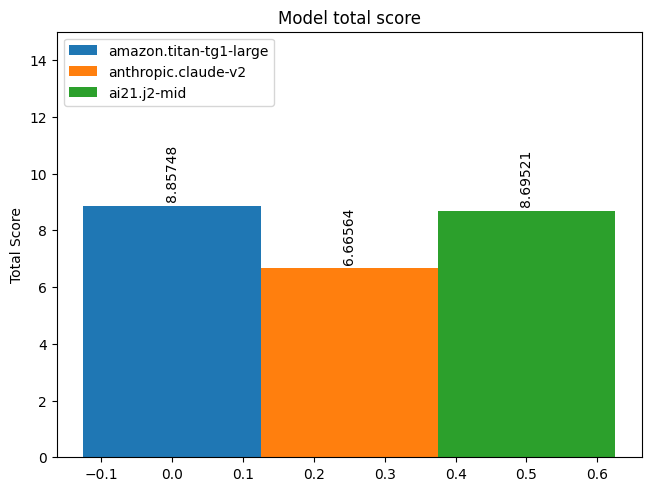

In [24]:
import matplotlib.pyplot as plt
import numpy as np

metrics_scores = {}
model_names = []
x_labels = ["Total Score"]
metric_names = []
for metric_ in metrics:
    metric_names.append(metric_["metric_name"])
for model in models:
    model_names.append(model["model_name"])
    dataset = pd.read_csv(f"evaluation_dataset_{model['model_name']}.csv", "|")
    metrics_scores[model["model_name"]] = [0]
    for ind in dataset.index:
        scores = 0
        for metric_name in metric_names:
            scores += dataset[metric_name][ind]
        metrics_scores[model["model_name"]][0] = scores


x = np.arange(len(x_labels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in metrics_scores.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, rotation=90)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total Score')
ax.set_title('Model total score')
# ax.set_xticks(x + width, x_labels, rotation=70)
ax.legend(loc='upper left')
ax.set_ylim(0, 15)

plt.show()

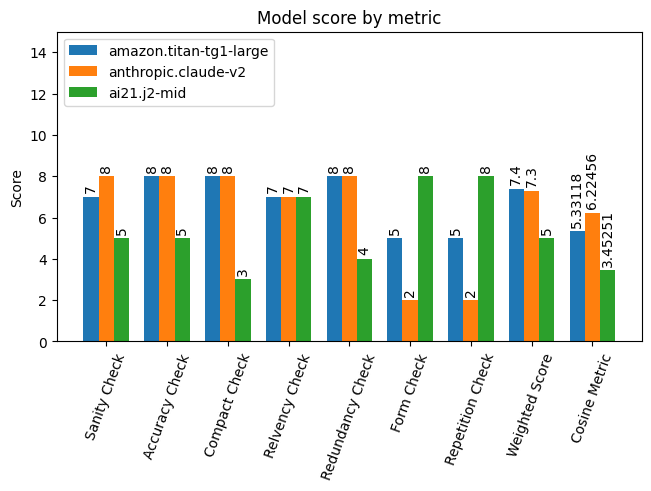

In [25]:
import matplotlib.pyplot as plt
import numpy as np

metrics_scores = {}
model_names = []
metric_names = []
for metric_ in metrics:
    metric_names.append(metric_["metric_name"])
for model in models:
    model_names.append(model["model_name"])
    dataset = pd.read_csv(f"evaluation_dataset_{model['model_name']}.csv", "|")
    metrics_scores[model["model_name"]] = [0] * len(metric_names)
    for ind in dataset.index:
        scores = []
        for metric_name in metric_names:
            scores.append(dataset[metric_name][ind])
        for i, score in enumerate(scores): 
            metrics_scores[model["model_name"]][i] += score


x = np.arange(len(metric_names))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in metrics_scores.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, rotation=90)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Model score by metric')
ax.set_xticks(x + width, metric_names, rotation=70)
ax.legend(loc='upper left')
ax.set_ylim(0, 15)

plt.show()